## Topic classification using BERT Embeddings

In [1]:
import pandas as pd
df_cleaned = pd.read_csv("../data/cleaned_merged_all_articles.csv", index_col=0).drop(columns=['title', 'representative_name', 'representative_state', 'representative_party', 'representative_committee', 'date'])
df_single_issue = df_cleaned[~df_cleaned['issue'].str.contains(';')]
selected_issues = [
    "Energy and Environment", "Education", "Health Care and Social Security", "Jobs and the Economy",
				"National Security, Defence, Foreign Affairs", "Veterans and Military"
  ]
df = df_single_issue[df_single_issue['issue'].isin(selected_issues)]
df.groupby("issue")["text"].count()

issue
Education                                      1411
Energy and Environment                         2380
Health Care and Social Security                2930
Jobs and the Economy                           2333
National Security, Defence, Foreign Affairs    3673
Veterans and Military                          1376
Name: text, dtype: int64

In [2]:
import re
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

stop_words_path = "./SmartStoplist.txt"
lemmatizer = WordNetLemmatizer()

def load_stop_words():
    stop_words = []
    with open(stop_words_path, "r") as f:
        stop_words = f.read().split("\n")
    return set(stop_words)

def preprocess_text(text: str, stopwords) -> str:
    text = re.sub(r"http\S+", "", text) # remove links
    text = re.sub("[^A-Za-z]+", " ", text) # remove special characters and numbers
    tokens = nltk.word_tokenize(text.lower()) # tokenization
    tokens = [w for w in tokens if not w in stopwords] # remove stop words
    tokens = [lemmatizer.lemmatize(w) for w in tokens] # remove stop words + lemmatization
    text = " ".join(tokens)
    text = text.lower().strip()
    return text


stopwords = load_stop_words()
df.loc[:, "text"] = df["text"].apply(lambda text: preprocess_text(text, stopwords))
df = df[df["text"] != ""]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jakub\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


We want to use BERT solely for generating embeddings and then feed those embeddings into a separate neural network for classification, so we freeze the BERT model and use it as a feature extractor. This approach significantly reduces computational cost compared to fine-tuning the entire BERT model.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch import nn
import torch
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader, TensorDataset

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['issue'])

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
train_embeddings = sbert_model.encode(train_texts.tolist(), convert_to_tensor=True)
val_embeddings = sbert_model.encode(val_texts.tolist(), convert_to_tensor=True)

train_labels_tensor = torch.tensor(train_labels.values)
val_labels_tensor = torch.tensor(val_labels.values)

train_dataset = TensorDataset(train_embeddings, train_labels_tensor)
val_dataset = TensorDataset(val_embeddings, val_labels_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

c:\Studia\Magisterka2semestr\usa_issues_data_mining\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np


class SimpleNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

early_stopper = EarlyStopper(patience=3, min_delta=10)

def train(classifier, criterion, optimizer, train_loader, epochs=30):
	losses = []
	for epoch in range(epochs):  # Train for 10 epochs
					classifier.train()
					for batch in train_loader:
									optimizer.zero_grad()

									embeddings, labels = batch
									embeddings = embeddings.to(device)
									labels = labels.to(device).long()

									outputs = classifier(embeddings)
									loss = criterion(outputs, labels)
									loss.backward()
									optimizer.step()
									

					final_loss = loss.item()
					print(f"Epoch {epoch + 1}, Loss: {final_loss}")
					losses.append(final_loss)
					if early_stopper.early_stop(final_loss):
						break
	return losses

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [6]:
def evaluate(classifier, val_loader):
	classifier.eval()
	all_predictions = []
	all_labels = []
	with torch.no_grad():
					for batch in val_loader:
									embeddings, labels = batch
									embeddings = embeddings.to(device)
									labels = labels.to(device).long()

									outputs = classifier(embeddings)
									predictions = torch.argmax(outputs, dim=-1)

									all_predictions.extend(predictions.cpu().numpy())
									all_labels.extend(labels.cpu().numpy())

	# Generate classification report
	print(classification_report(all_labels, all_predictions, target_names=label_encoder.classes_))

	# Generate confusion matrix
	cm = confusion_matrix(all_labels, all_predictions)
	cm_display_labels = label_encoder.classes_

	# Plot confusion matrix
	plt.figure(figsize=(10, 8))
	sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_display_labels, yticklabels=cm_display_labels)
	plt.xlabel('Predicted Label')
	plt.ylabel('True Label')
	plt.title('Confusion Matrix')
	plt.show()

In [7]:
model_simple = SimpleNN(input_dim=train_embeddings.size(1), num_classes=len(df['issue'].unique()))
model_simple.to(device)

criterion_cros_entr_loss = nn.CrossEntropyLoss()
optimizer_adam = torch.optim.Adam(model_simple.parameters(), lr=1e-4)

In [8]:
train(model_simple, criterion_cros_entr_loss, optimizer_adam, train_loader, 30)

Epoch 1, Loss: 1.5087494850158691
Epoch 2, Loss: 1.4291985034942627
Epoch 3, Loss: 0.7006878852844238
Epoch 4, Loss: 1.0617647171020508
Epoch 5, Loss: 0.6858131885528564
Epoch 6, Loss: 0.6193739771842957
Epoch 7, Loss: 0.8744239807128906
Epoch 8, Loss: 0.5510420203208923
Epoch 9, Loss: 0.17585760354995728
Epoch 10, Loss: 0.5541247725486755
Epoch 11, Loss: 0.3667038381099701
Epoch 12, Loss: 0.3815564811229706
Epoch 13, Loss: 0.7025206089019775
Epoch 14, Loss: 0.4705747365951538
Epoch 15, Loss: 0.24567811191082
Epoch 16, Loss: 0.4464411735534668
Epoch 17, Loss: 0.1998869776725769
Epoch 18, Loss: 0.34389355778694153
Epoch 19, Loss: 0.5275272727012634
Epoch 20, Loss: 0.2990455627441406
Epoch 21, Loss: 0.43360981345176697
Epoch 22, Loss: 0.4013713598251343
Epoch 23, Loss: 0.39836248755455017
Epoch 24, Loss: 0.16393589973449707
Epoch 25, Loss: 0.38981467485427856
Epoch 26, Loss: 0.3010350465774536
Epoch 27, Loss: 0.260304719209671
Epoch 28, Loss: 0.5425448417663574
Epoch 29, Loss: 0.46829488

[1.5087494850158691,
 1.4291985034942627,
 0.7006878852844238,
 1.0617647171020508,
 0.6858131885528564,
 0.6193739771842957,
 0.8744239807128906,
 0.5510420203208923,
 0.17585760354995728,
 0.5541247725486755,
 0.3667038381099701,
 0.3815564811229706,
 0.7025206089019775,
 0.4705747365951538,
 0.24567811191082,
 0.4464411735534668,
 0.1998869776725769,
 0.34389355778694153,
 0.5275272727012634,
 0.2990455627441406,
 0.43360981345176697,
 0.4013713598251343,
 0.39836248755455017,
 0.16393589973449707,
 0.38981467485427856,
 0.3010350465774536,
 0.260304719209671,
 0.5425448417663574,
 0.4682948887348175,
 0.20986388623714447]

                                             precision    recall  f1-score   support

                                  Education       0.88      0.83      0.85       282
                     Energy and Environment       0.90      0.92      0.91       476
            Health Care and Social Security       0.89      0.93      0.91       586
                       Jobs and the Economy       0.81      0.78      0.80       467
National Security, Defence, Foreign Affairs       0.88      0.90      0.89       735
                      Veterans and Military       0.84      0.77      0.80       275

                                   accuracy                           0.87      2821
                                  macro avg       0.87      0.85      0.86      2821
                               weighted avg       0.87      0.87      0.87      2821



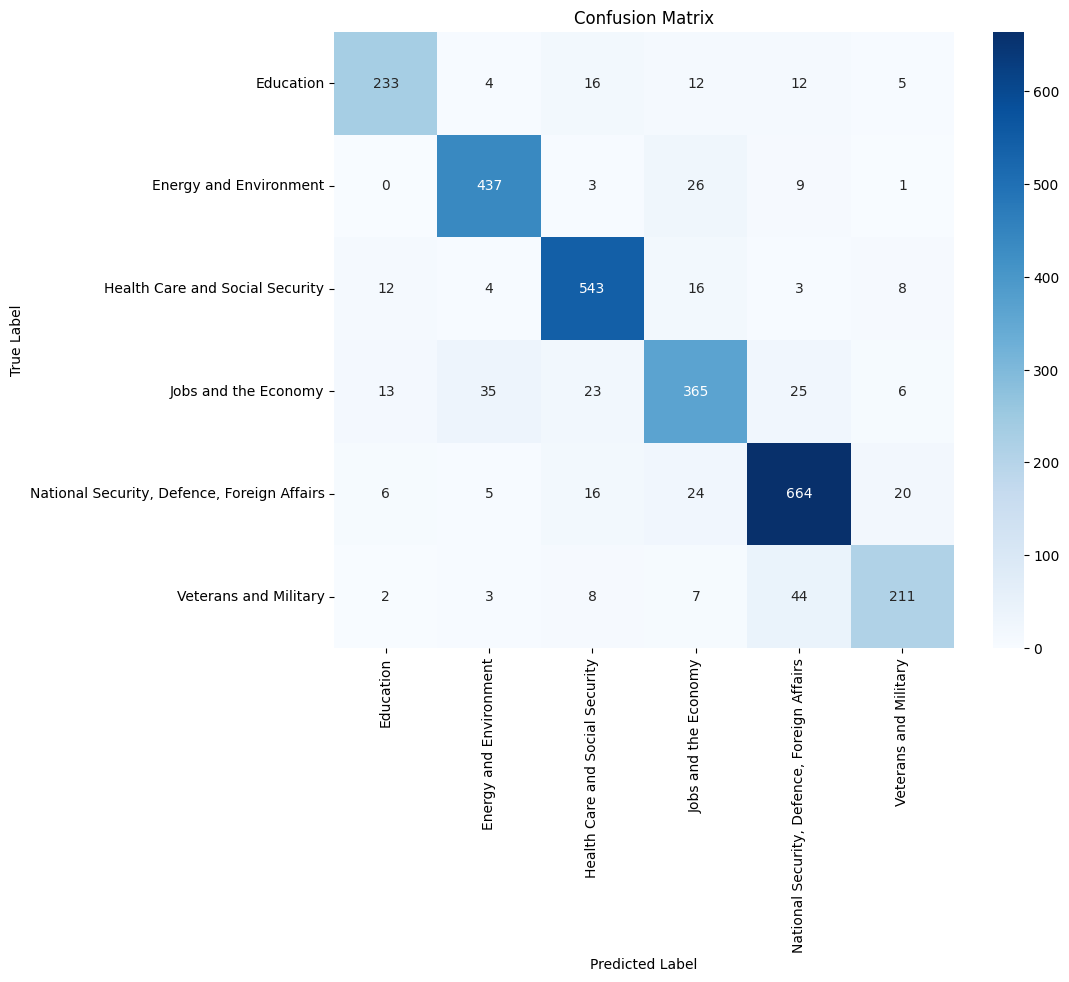

In [9]:
evaluate(model_simple, val_loader)

---

## Slightly more difficult model

In [10]:
class SlightlyMoreDifficultNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SlightlyMoreDifficultNN, self).__init__()
        self.fc = nn.Sequential(
								nn.Linear(input_dim, 256),
								nn.ReLU(),
								nn.Dropout(0.4),
								nn.Linear(256, 128),
								nn.ReLU(),
								nn.Dropout(0.3),
								nn.Linear(128, num_classes)
							)

    def forward(self, x):
        return self.fc(x)

In [11]:
model_more_diff = SlightlyMoreDifficultNN(input_dim=train_embeddings.size(1), num_classes=len(df['issue'].unique()))
model_more_diff.to(device)

criterion_cros_entr_loss = nn.CrossEntropyLoss()
optimizer_adam_diff = torch.optim.Adam(model_more_diff.parameters(), lr=5e-5, weight_decay=1e-4)

In [12]:
train(model_more_diff, criterion_cros_entr_loss, optimizer_adam_diff, train_loader, 100)

Epoch 1, Loss: 1.6163442134857178
Epoch 2, Loss: 1.1147170066833496
Epoch 3, Loss: 0.8879483938217163
Epoch 4, Loss: 0.5566003322601318
Epoch 5, Loss: 0.7498390078544617
Epoch 6, Loss: 0.7571567296981812
Epoch 7, Loss: 0.7337000370025635
Epoch 8, Loss: 0.8850609064102173
Epoch 9, Loss: 0.7877370715141296
Epoch 10, Loss: 0.8052883148193359
Epoch 11, Loss: 0.2953872084617615
Epoch 12, Loss: 0.8459630012512207
Epoch 13, Loss: 0.34586989879608154
Epoch 14, Loss: 0.4772487282752991
Epoch 15, Loss: 0.7140598297119141
Epoch 16, Loss: 0.8077196478843689
Epoch 17, Loss: 0.5526586174964905
Epoch 18, Loss: 0.7961195111274719
Epoch 19, Loss: 0.631173849105835
Epoch 20, Loss: 0.34403693675994873
Epoch 21, Loss: 0.5184983015060425
Epoch 22, Loss: 0.6825922727584839
Epoch 23, Loss: 0.06203034147620201
Epoch 24, Loss: 0.23817791044712067
Epoch 25, Loss: 0.31835782527923584
Epoch 26, Loss: 0.34518083930015564
Epoch 27, Loss: 0.12423251569271088
Epoch 28, Loss: 0.560589611530304
Epoch 29, Loss: 0.576117

[1.6163442134857178,
 1.1147170066833496,
 0.8879483938217163,
 0.5566003322601318,
 0.7498390078544617,
 0.7571567296981812,
 0.7337000370025635,
 0.8850609064102173,
 0.7877370715141296,
 0.8052883148193359,
 0.2953872084617615,
 0.8459630012512207,
 0.34586989879608154,
 0.4772487282752991,
 0.7140598297119141,
 0.8077196478843689,
 0.5526586174964905,
 0.7961195111274719,
 0.631173849105835,
 0.34403693675994873,
 0.5184983015060425,
 0.6825922727584839,
 0.06203034147620201,
 0.23817791044712067,
 0.31835782527923584,
 0.34518083930015564,
 0.12423251569271088,
 0.560589611530304,
 0.5761178731918335,
 0.19718320667743683,
 0.5887840390205383,
 0.23478929698467255,
 0.15569287538528442,
 0.6472108364105225,
 0.21283979713916779,
 0.34438443183898926,
 0.3710090219974518,
 0.5539494752883911,
 0.2508307695388794,
 0.31715941429138184,
 0.17852288484573364,
 0.17793582379817963,
 0.4204493761062622,
 0.22868625819683075,
 0.6178444027900696,
 0.763276994228363,
 0.2369135022163391,


                                             precision    recall  f1-score   support

                                  Education       0.89      0.86      0.88       282
                     Energy and Environment       0.90      0.93      0.91       476
            Health Care and Social Security       0.91      0.93      0.92       586
                       Jobs and the Economy       0.82      0.80      0.81       467
National Security, Defence, Foreign Affairs       0.90      0.93      0.91       735
                      Veterans and Military       0.88      0.81      0.85       275

                                   accuracy                           0.89      2821
                                  macro avg       0.89      0.88      0.88      2821
                               weighted avg       0.89      0.89      0.89      2821



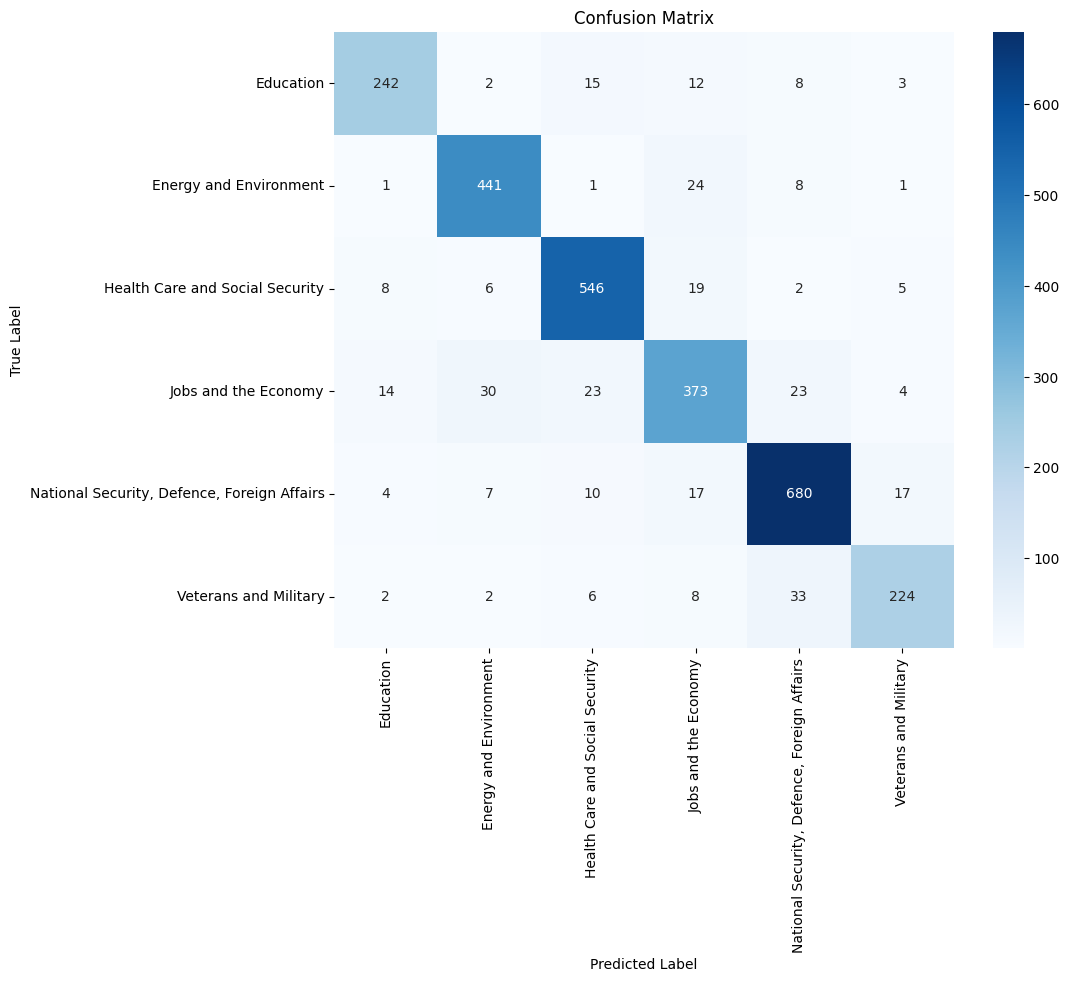

In [13]:
evaluate(model_more_diff, val_loader)

---

## 3rd model - 3 hidden layers

In [14]:
early_stopper = EarlyStopper(patience=3, min_delta=10)
class ImprovedNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ImprovedNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

In [15]:
model_improved = ImprovedNN(input_dim=train_embeddings.size(1), num_classes=len(df['issue'].unique()))
model_improved.to(device)

criterion_cros_entr_loss = nn.CrossEntropyLoss()
optimizer_adam_im = torch.optim.Adam(model_improved.parameters(), lr=1e-4, weight_decay=1e-4)

In [16]:
losses = train(model_improved, criterion_cros_entr_loss, optimizer_adam_im, train_loader, 300)

Epoch 1, Loss: 1.5724353790283203
Epoch 2, Loss: 0.8150683641433716
Epoch 3, Loss: 0.6562389135360718
Epoch 4, Loss: 0.8022341728210449
Epoch 5, Loss: 0.8321717977523804
Epoch 6, Loss: 0.4870842397212982
Epoch 7, Loss: 0.4638660252094269
Epoch 8, Loss: 0.33201730251312256
Epoch 9, Loss: 0.403820663690567
Epoch 10, Loss: 0.6994184851646423
Epoch 11, Loss: 0.39758437871932983
Epoch 12, Loss: 0.6860297322273254
Epoch 13, Loss: 0.46837589144706726
Epoch 14, Loss: 0.10169044882059097
Epoch 15, Loss: 0.6015831828117371
Epoch 16, Loss: 0.5061396956443787
Epoch 17, Loss: 0.3002535104751587
Epoch 18, Loss: 0.16619950532913208
Epoch 19, Loss: 0.6046776175498962
Epoch 20, Loss: 0.5009170770645142
Epoch 21, Loss: 0.3402329683303833
Epoch 22, Loss: 0.44669002294540405
Epoch 23, Loss: 0.477328360080719
Epoch 24, Loss: 0.20160438120365143
Epoch 25, Loss: 0.603705644607544
Epoch 26, Loss: 0.20829589664936066
Epoch 27, Loss: 0.08630184829235077
Epoch 28, Loss: 0.33713531494140625
Epoch 29, Loss: 0.1458

                                             precision    recall  f1-score   support

                                  Education       0.91      0.88      0.90       282
                     Energy and Environment       0.92      0.93      0.92       476
            Health Care and Social Security       0.92      0.94      0.93       586
                       Jobs and the Economy       0.85      0.85      0.85       467
National Security, Defence, Foreign Affairs       0.93      0.94      0.94       735
                      Veterans and Military       0.89      0.86      0.88       275

                                   accuracy                           0.91      2821
                                  macro avg       0.91      0.90      0.90      2821
                               weighted avg       0.91      0.91      0.91      2821



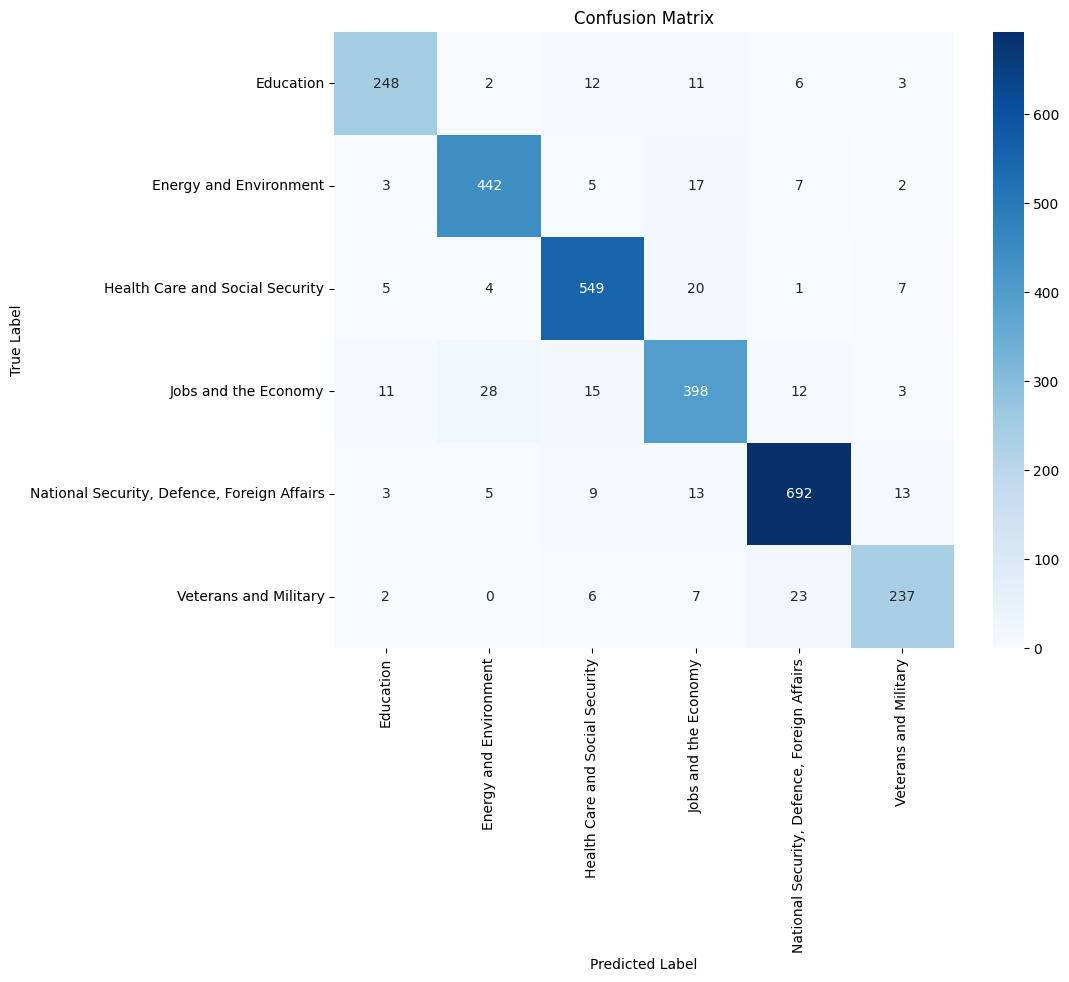

In [17]:
evaluate(model_improved, val_loader)

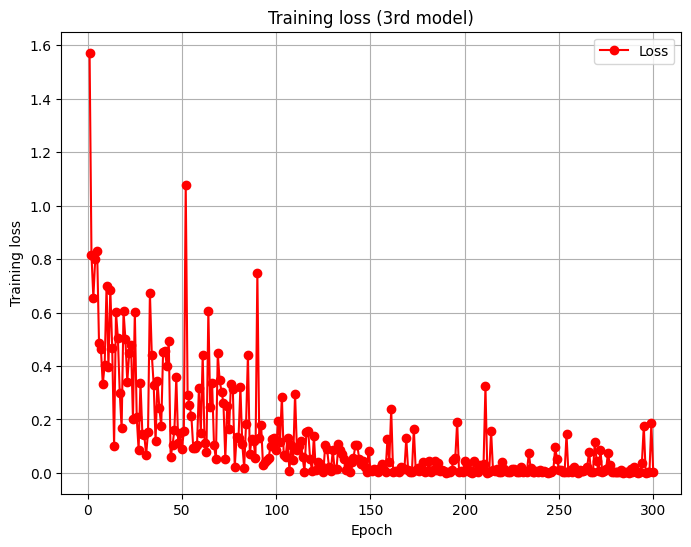

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(list(range(1, len(losses)+1)), losses, marker='o', linestyle='-', color='r', label='Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title('Training loss (3rd model)')
plt.legend()

# Show the plot
plt.grid()
plt.show()

----

## 4th model - 4 hidden layers

In [19]:
early_stopper = EarlyStopper(patience=3, min_delta=10)
class Improved2NN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Improved2NN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

In [20]:
model_improved2 = Improved2NN(input_dim=train_embeddings.size(1), num_classes=len(df['issue'].unique()))
model_improved2.to(device)

criterion_cros_entr_loss = nn.CrossEntropyLoss()
optimizer_adam_im2 = torch.optim.Adam(model_improved2.parameters(), lr=1e-4, weight_decay=1e-4)

In [21]:
losses = train(model_improved2, criterion_cros_entr_loss, optimizer_adam_im2, train_loader, 300)

Epoch 1, Loss: 1.5525507926940918
Epoch 2, Loss: 0.9491690397262573
Epoch 3, Loss: 1.083193302154541
Epoch 4, Loss: 0.6099136471748352
Epoch 5, Loss: 0.9666510820388794
Epoch 6, Loss: 0.3095029592514038
Epoch 7, Loss: 0.5580816268920898
Epoch 8, Loss: 0.9340090155601501
Epoch 9, Loss: 0.5591871738433838
Epoch 10, Loss: 0.44685766100883484
Epoch 11, Loss: 0.39368879795074463
Epoch 12, Loss: 0.49873781204223633
Epoch 13, Loss: 0.2516109347343445
Epoch 14, Loss: 0.6888108849525452
Epoch 15, Loss: 0.324531614780426
Epoch 16, Loss: 0.2917909026145935
Epoch 17, Loss: 0.5816605091094971
Epoch 18, Loss: 0.8238465189933777
Epoch 19, Loss: 0.2168068289756775
Epoch 20, Loss: 0.466970294713974
Epoch 21, Loss: 0.2486373782157898
Epoch 22, Loss: 0.1482323557138443
Epoch 23, Loss: 0.7626581192016602
Epoch 24, Loss: 0.6205742359161377
Epoch 25, Loss: 0.2756116986274719
Epoch 26, Loss: 0.32271257042884827
Epoch 27, Loss: 0.5057901740074158
Epoch 28, Loss: 0.3643566370010376
Epoch 29, Loss: 0.3388822376

                                             precision    recall  f1-score   support

                                  Education       0.89      0.86      0.87       282
                     Energy and Environment       0.91      0.93      0.92       476
            Health Care and Social Security       0.91      0.93      0.92       586
                       Jobs and the Economy       0.85      0.84      0.85       467
National Security, Defence, Foreign Affairs       0.93      0.94      0.94       735
                      Veterans and Military       0.89      0.86      0.88       275

                                   accuracy                           0.90      2821
                                  macro avg       0.90      0.89      0.90      2821
                               weighted avg       0.90      0.90      0.90      2821



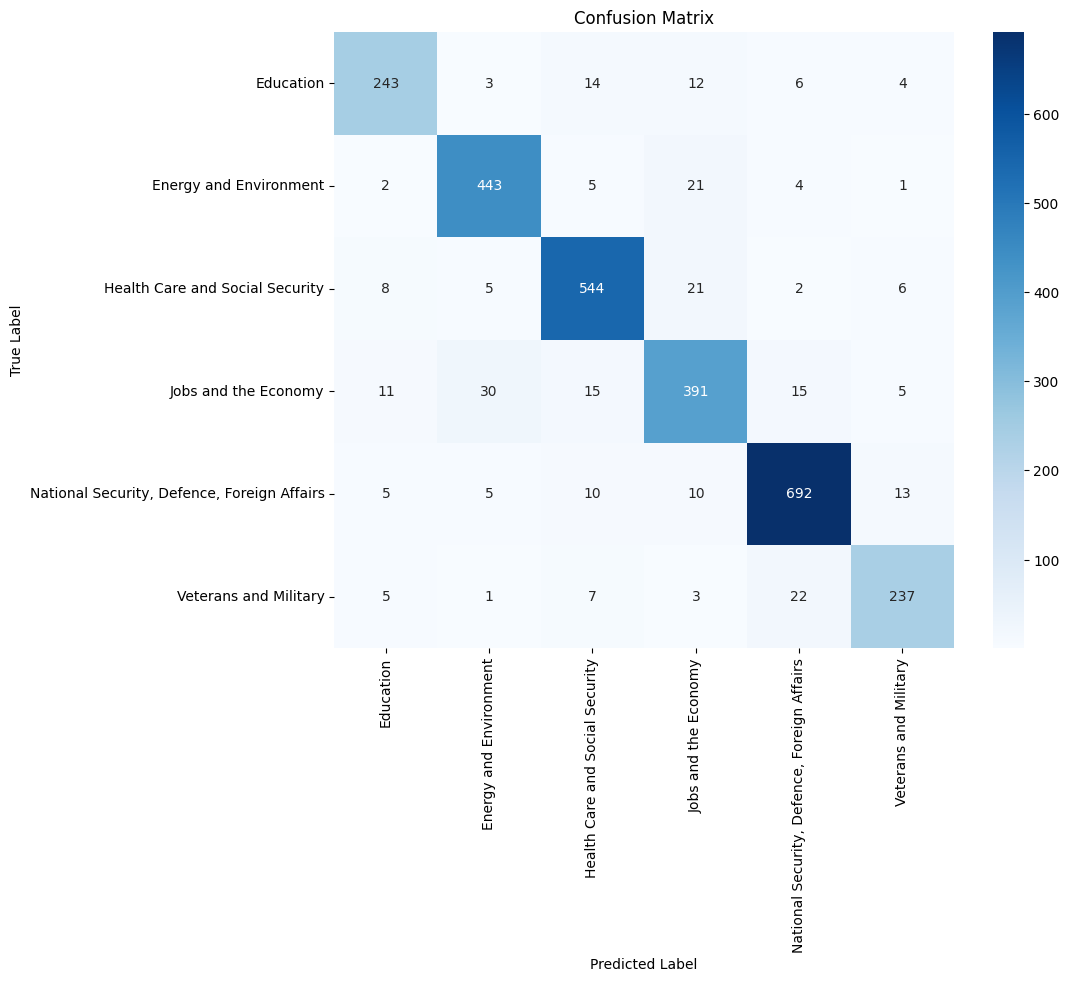

In [22]:
evaluate(model_improved2, val_loader)

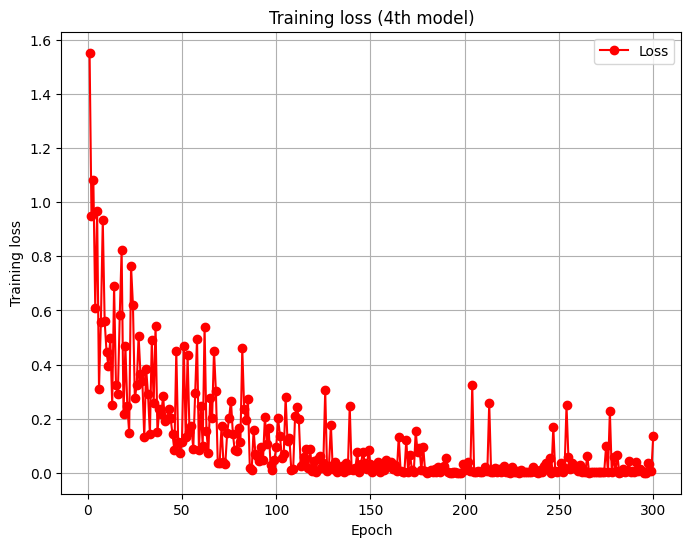

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(list(range(1, len(losses)+1)), losses, marker='o', linestyle='-', color='r', label='Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title('Training loss (4th model)')
plt.legend()

# Show the plot
plt.grid()
plt.show()

---

## 5th model - 5 hidden layers

In [24]:
class Improved3NN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Improved3NN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

model_improved3 = Improved3NN(input_dim=train_embeddings.size(1), num_classes=len(df['issue'].unique()))
model_improved3.to(device)

criterion_cros_entr_loss = nn.CrossEntropyLoss()
optimizer_adam_im3 = torch.optim.Adam(model_improved3.parameters(), lr=1e-4, weight_decay=1e-4)

losses = train(model_improved3, criterion_cros_entr_loss, optimizer_adam_im3, train_loader, 400)

Epoch 1, Loss: 1.6102168560028076
Epoch 2, Loss: 1.4346119165420532
Epoch 3, Loss: 0.8599342703819275
Epoch 4, Loss: 1.0160531997680664
Epoch 5, Loss: 0.7650810480117798
Epoch 6, Loss: 0.7653367519378662
Epoch 7, Loss: 0.9303997755050659
Epoch 8, Loss: 0.6950929164886475
Epoch 9, Loss: 0.8190450072288513
Epoch 10, Loss: 0.6314138174057007
Epoch 11, Loss: 0.5385773181915283
Epoch 12, Loss: 0.5047122836112976
Epoch 13, Loss: 0.46390077471733093
Epoch 14, Loss: 0.8385190963745117
Epoch 15, Loss: 0.34124624729156494
Epoch 16, Loss: 0.6790566444396973
Epoch 17, Loss: 0.5977872014045715
Epoch 18, Loss: 0.8637958765029907
Epoch 19, Loss: 0.5180634260177612
Epoch 20, Loss: 0.29716143012046814
Epoch 21, Loss: 0.40570658445358276
Epoch 22, Loss: 0.43630728125572205
Epoch 23, Loss: 0.5264343619346619
Epoch 24, Loss: 0.11251650750637054
Epoch 25, Loss: 0.145704448223114
Epoch 26, Loss: 0.7340060472488403
Epoch 27, Loss: 0.14286865293979645
Epoch 28, Loss: 0.4689418375492096
Epoch 29, Loss: 0.53483

                                             precision    recall  f1-score   support

                                  Education       0.91      0.85      0.88       282
                     Energy and Environment       0.92      0.90      0.91       476
            Health Care and Social Security       0.92      0.94      0.93       586
                       Jobs and the Economy       0.83      0.84      0.84       467
National Security, Defence, Foreign Affairs       0.92      0.95      0.94       735
                      Veterans and Military       0.91      0.87      0.89       275

                                   accuracy                           0.90      2821
                                  macro avg       0.90      0.89      0.90      2821
                               weighted avg       0.90      0.90      0.90      2821



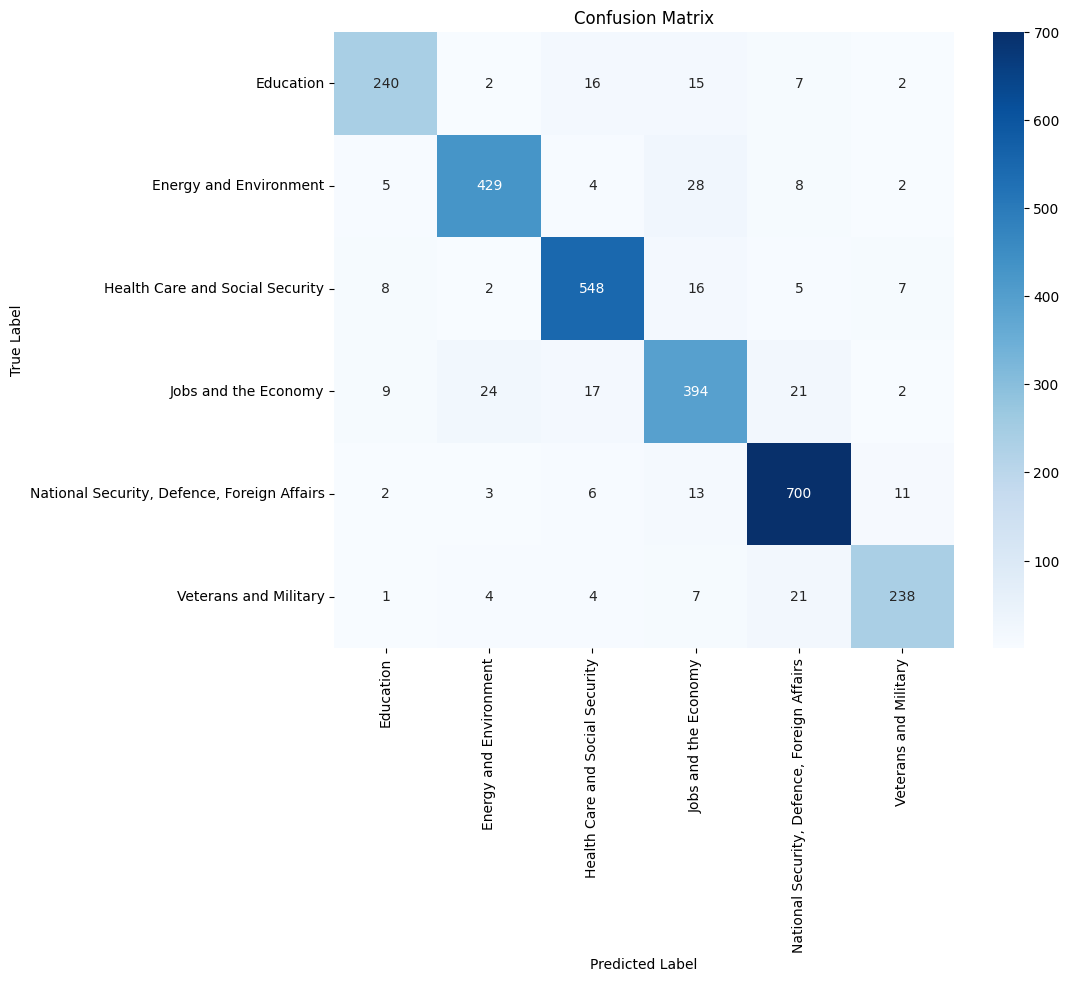

In [25]:
evaluate(model_improved3, val_loader)

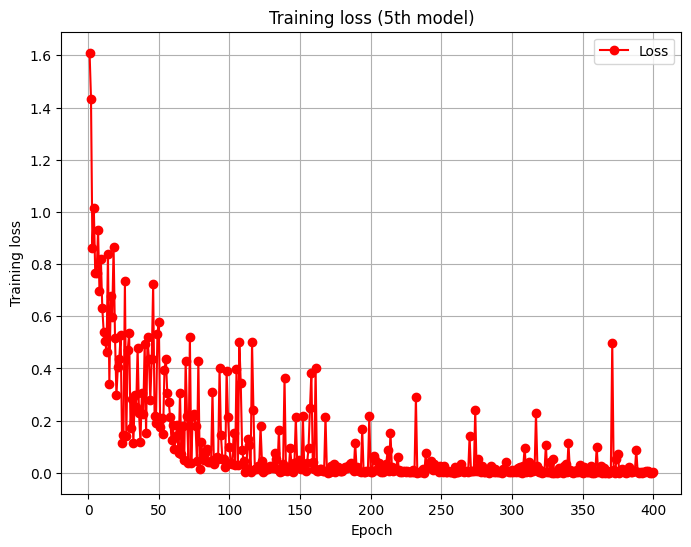

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(list(range(1, len(losses)+1)), losses, marker='o', linestyle='-', color='r', label='Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title('Training loss (5th model)')
plt.legend()

# Show the plot
plt.grid()
plt.show()

---

## 6th model - 5th model with weighted loss

In [27]:
class Improved3NN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Improved3NN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

from sklearn.utils.class_weight import compute_class_weight
labels_tensor = torch.concat([train_labels_tensor, val_labels_tensor]) 
class_weights = compute_class_weight('balanced', classes=np.unique(labels_tensor), y=labels_tensor.numpy())
class_weights=torch.tensor(class_weights,dtype=torch.float)
print(class_weights)

model_improved6 = Improved3NN(input_dim=train_embeddings.size(1), num_classes=len(df['issue'].unique()))
model_improved6.to(device)

criterion_cros_entr_loss = nn.CrossEntropyLoss(weight=class_weights)
optimizer_adam_im6 = torch.optim.Adam(model_improved6.parameters(), lr=1e-4, weight_decay=1e-4)

losses = train(model_improved6, criterion_cros_entr_loss, optimizer_adam_im6, train_loader, 400)

tensor([1.6658, 0.9876, 0.8022, 1.0075, 0.6399, 1.7082])
Epoch 1, Loss: 1.7080191373825073
Epoch 2, Loss: 0.9924376606941223
Epoch 3, Loss: 0.8939319252967834
Epoch 4, Loss: 0.7719550728797913
Epoch 5, Loss: 0.5513676404953003
Epoch 6, Loss: 0.7083618640899658
Epoch 7, Loss: 0.9631035327911377
Epoch 8, Loss: 0.8516532182693481
Epoch 9, Loss: 0.469814658164978
Epoch 10, Loss: 0.8527284860610962
Epoch 11, Loss: 0.6748538017272949
Epoch 12, Loss: 0.5571678280830383
Epoch 13, Loss: 0.3755514919757843
Epoch 14, Loss: 0.9586490392684937
Epoch 15, Loss: 0.953490674495697
Epoch 16, Loss: 0.4593581259250641
Epoch 17, Loss: 0.3217317759990692
Epoch 18, Loss: 0.32183539867401123
Epoch 19, Loss: 0.2384720891714096
Epoch 20, Loss: 0.184147447347641
Epoch 21, Loss: 0.45040372014045715
Epoch 22, Loss: 0.7464829087257385
Epoch 23, Loss: 0.2902766466140747
Epoch 24, Loss: 0.657604992389679
Epoch 25, Loss: 0.4414256811141968
Epoch 26, Loss: 0.2441331446170807
Epoch 27, Loss: 0.573546290397644
Epoch 28, 

                                             precision    recall  f1-score   support

                                  Education       0.89      0.87      0.88       282
                     Energy and Environment       0.90      0.93      0.91       476
            Health Care and Social Security       0.92      0.93      0.93       586
                       Jobs and the Economy       0.84      0.82      0.83       467
National Security, Defence, Foreign Affairs       0.93      0.92      0.92       735
                      Veterans and Military       0.86      0.87      0.86       275

                                   accuracy                           0.90      2821
                                  macro avg       0.89      0.89      0.89      2821
                               weighted avg       0.90      0.90      0.90      2821



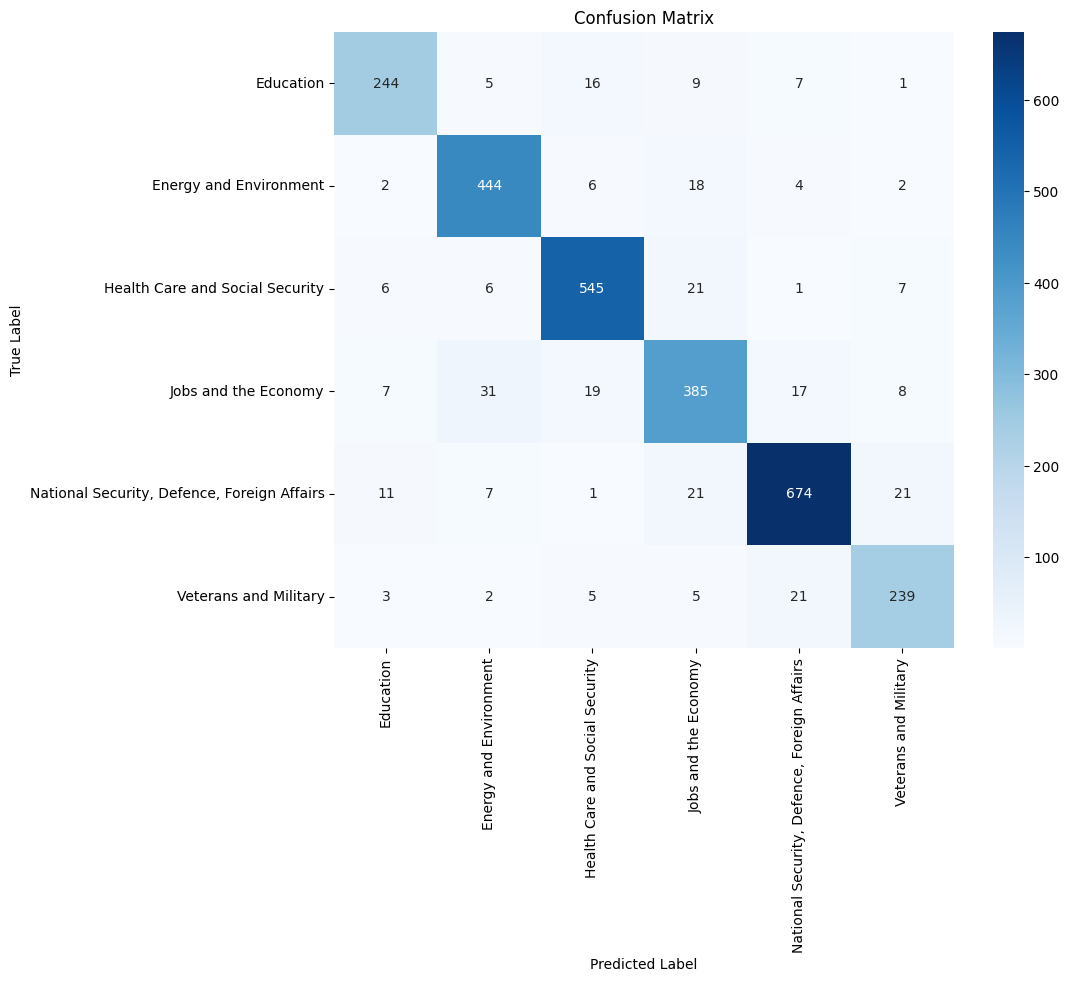

In [28]:
evaluate(model_improved6, val_loader)

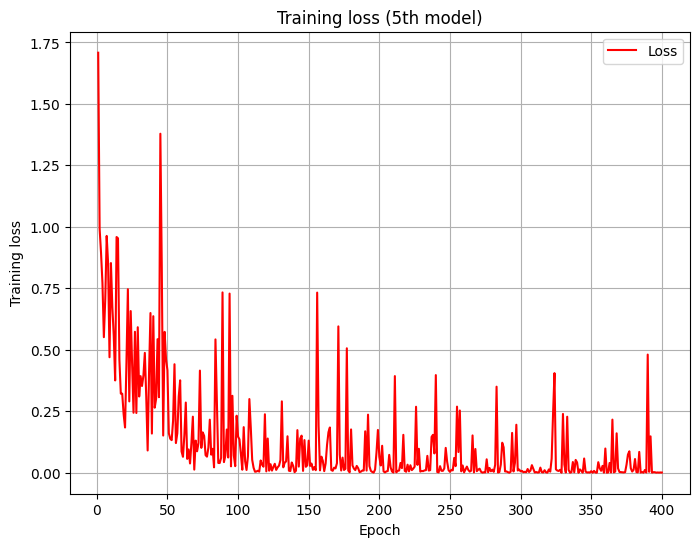

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(list(range(1, len(losses)+1)), losses, linestyle='-', color='r', label='Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title('Training loss (5th model)')
plt.legend()

# Show the plot
plt.grid()
plt.show()